In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import ROOT
from ROOT import TFile, TTree, TH1F, TCanvas, TAxis, TLegend, TTreeReader, TTreeReaderValue
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import StandardScaler

Welcome to JupyROOT 6.22/06


In [2]:
# inFile = TFile("/home/xyan13/Trijet/TrijetAna/TrijetAna/outputs/Res1ToRes2GluTo3Glu_M1-3000_R-0p5_ML_study.root")
# inTree = inFile.Get("Events")
# variable2use = [i.GetName() for i in inTree.GetListOfBranches()]
# display(variable2use)
# for branch in variable2use:
#     print(f"{branch}[0] = event.{branch}")

In [3]:
def make_df(outTree):
    data, columns = outTree.AsMatrix(return_labels=True)
    df_temp = pd.DataFrame(data=data, columns=columns)
#     display(df_temp.head())
    variables = [var for var in df_temp.columns[:len(df_temp.columns)-1]]
    df = df_temp.iloc[:, :len(df_temp.columns)-1]
    label = df_temp.iloc[:, len(df_temp.columns)-1:len(df_temp.columns)]
#     display(df.head())
#     display(label.head())
    return df, label

In [4]:
def eval_classification(df, label, model):
    # Manually calculate classificiation efficiency
    sig_index_list = np.where((label.values.ravel() == 1))[0].tolist()
    N_test = len(sig_index_list)
    clf_results_sig = np.array([])
    N_correct = 0
    N_tested = 0
    # for i in range((df.shape)[0]): # Test both sig and bkg
    #     index = i
    for i, index in enumerate(sig_index_list): # Test sig only
        if i % 1000 == 0:
            print(f"Reading: {i} out of {N_test}")
        is_correct = (label.values[index] == clf.predict(df[index:index+1])[0]) # If u use StandardScaler() to scale the data, need... 
        #...to be df[index:index+1, :], otherwise df[index:index+1]
        if is_correct:
            clf_results_sig = np.append(clf_results_sig, 1)
        else:
            clf_results_sig = np.append(clf_results_sig, 0)
        # save results and restart again to speed things up
        if i % 1000 == 0:
            N_correct += np.sum(clf_results_sig)
            N_tested += np.size(clf_results_sig)
            print(N_correct, N_tested)
            clf_results_sig = np.array([])
    # Save the results from last batch
    N_correct += np.sum(clf_results_sig)
    N_tested += np.size(clf_results_sig)
    # Calculate classification efficiency
    print(N_correct, N_tested, N_correct / N_tested)

In [5]:
def eval_regreesion(df, label, model):
    # Plot BDT output
    sig_index_list = np.where((label.values.ravel() == 1))[0].tolist()
    bkg_index_list = np.where((label.values.ravel() == 0))[0].tolist()
    print("Number of signals for testing: ", len(sig_index_list))
    print("Number of backgrounds for testing: ", len(sig_index_list))
    result_sig = clf.predict(df.iloc[sig_index_list])
    result_bkg = clf.predict(df.iloc[bkg_index_list])
    max_sig_response = max(result_sig)
    max_bkg_response = max(result_bkg)
    max_response = max([max_sig_response, max_bkg_response])
    # Manually calculate classificiation efficiency
    sig_eff_list = []
    bkg_rej_list = []
    sig_purity_list = []
    sensitivity_list = []
    cut_list = []
    cut_90eff = -1
    for cut in np.linspace(0,1,101):
        N_sig = len(sig_index_list)
        N_bkg = len(bkg_index_list)
        N_sig_pass = len([x for x in result_sig if x > cut])
        N_bkg_pass = len([x for x in result_bkg if x > cut])
        if(N_bkg_pass == 0 or (N_sig_pass + N_bkg_pass) == 0):
            print("Dividing zero, end loop")
            break
        cut_list.append(cut)
        sig_eff_list.append(N_sig_pass / N_sig)
        if abs((N_sig_pass / N_sig) - 0.9) < 0.01:
            print(N_sig_pass / N_sig, cut_90eff)
            cut_90eff = cut
        bkg_rej_list.append(1 - N_bkg_pass / N_bkg)
        sig_purity_list.append(N_sig_pass / (N_sig_pass + N_bkg_pass))
        sensitivity_list.append(N_sig_pass / math.sqrt(N_bkg_pass))
    fig = plt.figure()   
    ax0 = fig.add_subplot(3,1,1)
    plt.hist(result_sig,50, color='r', alpha=0.5, label="match")
    plt.hist(result_bkg,50, color='b', alpha=0.5, label="unmatch")
    ax0.set_ylabel("Events")
    ax0.set_xlabel("BDT response")
    ax0.set_xlim(-0.01,max_response+0.05)
    handles, labels = ax0.get_legend_handles_labels()
    ax0.legend(handles, labels)
    ax1 = fig.add_subplot(3,1,2)
    ax1.plot(cut_list, sig_eff_list, label="Signal efficiency", color="red")
    ax1.plot(cut_list, bkg_rej_list, label="Background rejection", color="blue")
    ax1.plot(cut_list, sig_purity_list, label="Signal purity", color="green") 
    ax1.set_ylabel("")
    ax1.set_xlabel("Cut on BDT")
    ax1.set_xlim(-0.01,max_response+0.05)
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles, labels)
    ax1.grid(True)
    ax2 = fig.add_subplot(3,1,3)
    ax2.plot(cut_list, sensitivity_list, label=r"$S/\sqrt{B}$", color="black")
    ax2.set_ylabel("")
    ax2.set_xlabel("Cut on BDT")
    ax2.set_xlim(-0.01,max_response+0.05)
    handles, labels = ax2.get_legend_handles_labels()
    ax2.legend(handles, labels)
    ax2.grid(True)
    fig.set_figheight(20)
    fig.set_figwidth(12)
    print("90% signal efficiency cut: ", cut_90eff)
    print("Optimal cut on BDT: ", cut_list[sensitivity_list.index(max(sensitivity_list))])
    fig.show()

In [6]:
sample = "M1-3000_R-0p3"
tempFile = TFile(f"{sample}_training.root","RECREATE")
outTree = TTree()
inFile = TFile(f"/home/xyan13/Trijet/TrijetAna/TrijetAna/outputs/Res1ToRes2GluTo3Glu_{sample}_ML_study.root")
inTree = inFile.Get("Events")
dijet_eta = np.empty((1), dtype="float32")
dijet_phi = np.empty((1), dtype="float32")
dR_jj = np.empty((1), dtype="float32")
dEta_jj = np.empty((1), dtype="float32")
dPhi_jj = np.empty((1), dtype="float32")
jet_eta_0 = np.empty((1), dtype="float32")
jet_phi_0 = np.empty((1), dtype="float32")
jet_ptoverm_0 = np.empty((1), dtype="float32")
jet_eta_1 = np.empty((1), dtype="float32")
jet_phi_1 = np.empty((1), dtype="float32")
jet_ptoverm_1 = np.empty((1), dtype="float32")
jet_eta_2 = np.empty((1), dtype="float32")
jet_phi_2 = np.empty((1), dtype="float32")
jet_ptoverm_2 = np.empty((1), dtype="float32")
dR_jj_j = np.empty((1), dtype="float32")
dEta_jj_j = np.empty((1), dtype="float32")
dPhi_jj_j = np.empty((1), dtype="float32")
jet_ptoverM_0 = np.empty((1), dtype="float32")
jet_ptoverM_1 = np.empty((1), dtype="float32")
jet_ptoverM_2 = np.empty((1), dtype="float32")
dijet_ptoverM = np.empty((1), dtype="float32")
gen_dijet_matched = np.empty((1), dtype="int32")

outTree.Branch("dijet_eta", dijet_eta, "dijet_eta/F")
outTree.Branch("dijet_phi", dijet_phi, "dijet_phi/F")
outTree.Branch("dR_jj", dR_jj, "dR_jj/F")
outTree.Branch("dEta_jj", dEta_jj, "dEta_jj/F")
outTree.Branch("dPhi_jj", dPhi_jj, "dPhi_jj/F")
outTree.Branch("jet_eta_0", jet_eta_0, "jet_eta_0/F")
outTree.Branch("jet_phi_0", jet_phi_0, "jet_phi_0/F")
outTree.Branch("jet_ptoverm_0", jet_ptoverm_0, "jet_ptoverm_0/F")
outTree.Branch("jet_eta_1", jet_eta_1, "jet_eta_1/F")
outTree.Branch("jet_phi_1", jet_phi_1, "jet_phi_1/F")
outTree.Branch("jet_ptoverm_1", jet_ptoverm_1, "jet_ptoverm_1/F")
outTree.Branch("jet_eta_2", jet_eta_2, "jet_eta_2/F")
outTree.Branch("jet_phi_2", jet_phi_2, "jet_phi_2/F")
outTree.Branch("jet_ptoverm_2", jet_ptoverm_2, "jet_ptoverm_2/F")
outTree.Branch("dR_jj_j", dR_jj_j, "dR_jj_j/F")
outTree.Branch("dEta_jj_j", dEta_jj_j, "dEta_jj_j/F")
outTree.Branch("dPhi_jj_j", dPhi_jj_j, "dPhi_jj_j/F")
outTree.Branch("jet_ptoverM_0", jet_ptoverM_0, "jet_ptoverM_0/F")
outTree.Branch("jet_ptoverM_1", jet_ptoverM_1, "jet_ptoverM_1/F")
outTree.Branch("jet_ptoverM_2", jet_ptoverM_2, "jet_ptoverM_2/F")
outTree.Branch("dijet_ptoverM", dijet_ptoverM, "dijet_ptoverM/F")
outTree.Branch("gen_dijet_matched", gen_dijet_matched, "gen_dijet_matched/I")

n_all = inTree.GetEntries()
array_ismatch = inTree.AsMatrix(columns=["gen_dijet_matched"])
array_matched = np.where((array_ismatch.ravel() == 3))[0]
n_matched = np.shape(array_matched)[0]
array_unmatched = np.where((array_ismatch.ravel() == 0))[0]
n_unmatched = np.shape(array_unmatched)[0]
print(n_matched, n_unmatched)
ratio = n_matched / n_unmatched
from ROOT import TRandom3
rand_gen = TRandom3()
count_unmatch = 0
for i, event in enumerate(inTree):
    if i%10000 == 0:
        print("Processing: ",i)
    if(event.gen_dijet_matched != 0 and event.gen_dijet_matched != 3): continue
    if(event.gen_dijet_matched == 0):
        random = rand_gen.Uniform(0,1)
        if random > ratio: 
            continue
        gen_dijet_matched[0] = 0
    else:
        gen_dijet_matched[0] = 1
    dijet_eta[0] = event.dijet_eta
    dijet_phi[0] = event.dijet_phi
    dR_jj[0] = event.dR_jj
    dEta_jj[0] = event.dEta_jj
    dPhi_jj[0] = event.dPhi_jj
    jet_eta_0[0] = event.jet_eta_0
    jet_phi_0[0] = event.jet_phi_0
    jet_ptoverm_0[0] = event.jet_ptoverm_0
    jet_eta_1[0] = event.jet_eta_1
    jet_phi_1[0] = event.jet_phi_1
    jet_ptoverm_1[0] = event.jet_ptoverm_1
    jet_eta_2[0] = event.jet_eta_2
    jet_phi_2[0] = event.jet_phi_2
    jet_ptoverm_2[0] = event.jet_ptoverm_2
    dR_jj_j[0] = event.dR_jj_j
    dEta_jj_j[0] = event.dEta_jj_j
    dPhi_jj_j[0] = event.dPhi_jj_j
    jet_ptoverM_0[0] = event.jet_ptoverM_0
    jet_ptoverM_1[0] = event.jet_ptoverM_1
    jet_ptoverM_2[0] = event.jet_ptoverM_2
    dijet_ptoverM[0] = event.dijet_ptoverM
    outTree.Fill()
df_1 = pd.DataFrame()
label_1 = pd.DataFrame()
df_1, label_1 = make_df(outTree)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df_1, label_1, test_size=0.33, random_state=1, stratify=label_1)

25367 88894
Processing:  0
Processing:  10000
Processing:  20000
Processing:  30000
Processing:  40000
Processing:  50000
Processing:  60000
Processing:  70000
Processing:  80000
Processing:  90000
Processing:  100000
Processing:  110000
Processing:  120000
Processing:  130000
Processing:  140000
Processing:  150000
Processing:  160000
Processing:  170000
Processing:  180000
Processing:  190000
Processing:  200000
Processing:  210000
Processing:  220000
Processing:  230000
Processing:  240000
Processing:  250000
Processing:  260000
Processing:  270000
Processing:  280000
Processing:  290000
Processing:  300000
Processing:  310000
Processing:  320000
Processing:  330000
Processing:  340000
Processing:  350000
Processing:  360000
Processing:  370000
Processing:  380000
Processing:  390000
Processing:  400000


In [7]:
#This cell is intended for the single traning
print(label_1.head())
print(df_1.shape)
df_train = X_train_1
label_train = y_train_1
print(df_train.shape[0])
df_test = X_test_1
label_test = y_test_1

   gen_dijet_matched
0                1.0
1                0.0
2                0.0
3                0.0
4                1.0
(50633, 21)
33924


In [ ]:
# This cell is intended for mix traning using two samples
N2train = min(X_train_1.shape[0], X_train_2.shape[0])
print(N2train)
df_train = pd.concat([X_train_1.iloc[:N2train, :], X_train_2.iloc[:N2train, :]])
label_train = pd.concat([y_train_1.iloc[:N2train, :], y_train_2.iloc[:N2train, :]])
print(df_train.shape[0])
N2test = min(X_test_1.shape[0], X_test_2.shape[0])
print(N2test)
df_test = pd.concat([X_test_1.iloc[:N2test, :], X_test_2.iloc[:N2test, :]])
label_test = pd.concat([y_test_1.iloc[:N2test, :], y_test_2.iloc[:N2test, :]])
print(df_test.shape[0])

In [ ]:
# This cell is intended for PCA analysis, can be run seperately from ML traning
variables = [var for var in df_1.columns[:len(df_1.columns)]]
print(variables)
scaled_df = preprocessing.scale(df_1)
pca = PCA(0.95)
pca.fit(scaled_df)
PCA_df = pca.transform(scaled_df)
PCA_df = pd.DataFrame(data = PCA_df[:,:2],columns = ["PC1","PC2"])
PCA_df_final = pd.concat([PCA_df,label_1] ,axis = 1)
display(PCA_df_final.head())
# Calculate percentage variation
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals = 1)
# Calculate loading scores, determine best variables of each PCs
for i in range(0, len(per_var)):
    loading_scores = pd.Series(pca.components_[i], index=variables)
    loading_scores = loading_scores.abs().sort_values(ascending=False)
    display(loading_scores[:3])
labels = ["PC" + str(x) for x in range(1, len(per_var)+1)]
plt.figure(figsize=(20,10))
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel("% of explained variance")
plt.xlabel("PC")
plt.xticks(rotation=270)
plt.show()
# display(pca.components_)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1]
colors = ["b","r"]
for target, color in zip(targets,colors):
    indicesToKeep = PCA_df_final["gen_dijet_matched"] == target
    ax.scatter(PCA_df_final.loc[indicesToKeep, "PC1"],
               PCA_df_final.loc[indicesToKeep, "PC2"],
               c = color,
               s = 50)
ax.legend(targets)
ax.grid()

In [8]:
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# clf = MLPClassifier(solver='adam',hidden_layer_sizes=(20,20),random_state=1)
clf = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),n_estimators=200, random_state=1)
clf.fit(df_train, label_train.values.ravel())
# Score the fit using the pure QCD or Signal data
# X_test = scaler.transform(X_test)
# print(clf.score(X_test,y_test.values.ravel()))

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=4),
                  n_estimators=200, random_state=1)

Number of signals for testing:  8371
Number of backgrounds for testing:  8371
0.9058654879942659 -1
0.8908135228765978 0.51
Dividing zero, end loop
90% signal efficiency cut:  0.52
Optimal cut on BDT:  0.7000000000000001
Number of signals for testing:  16996
Number of backgrounds for testing:  16996
0.8997999529301012 -1
Dividing zero, end loop
90% signal efficiency cut:  0.52
Optimal cut on BDT:  0.7000000000000001


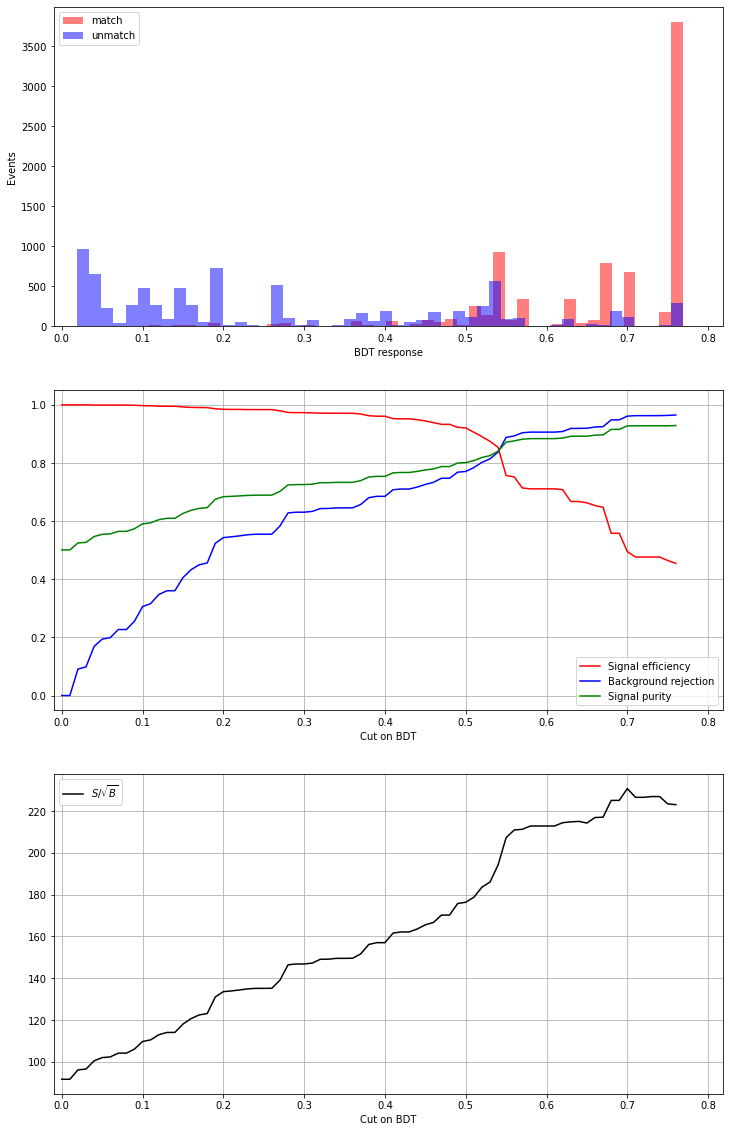

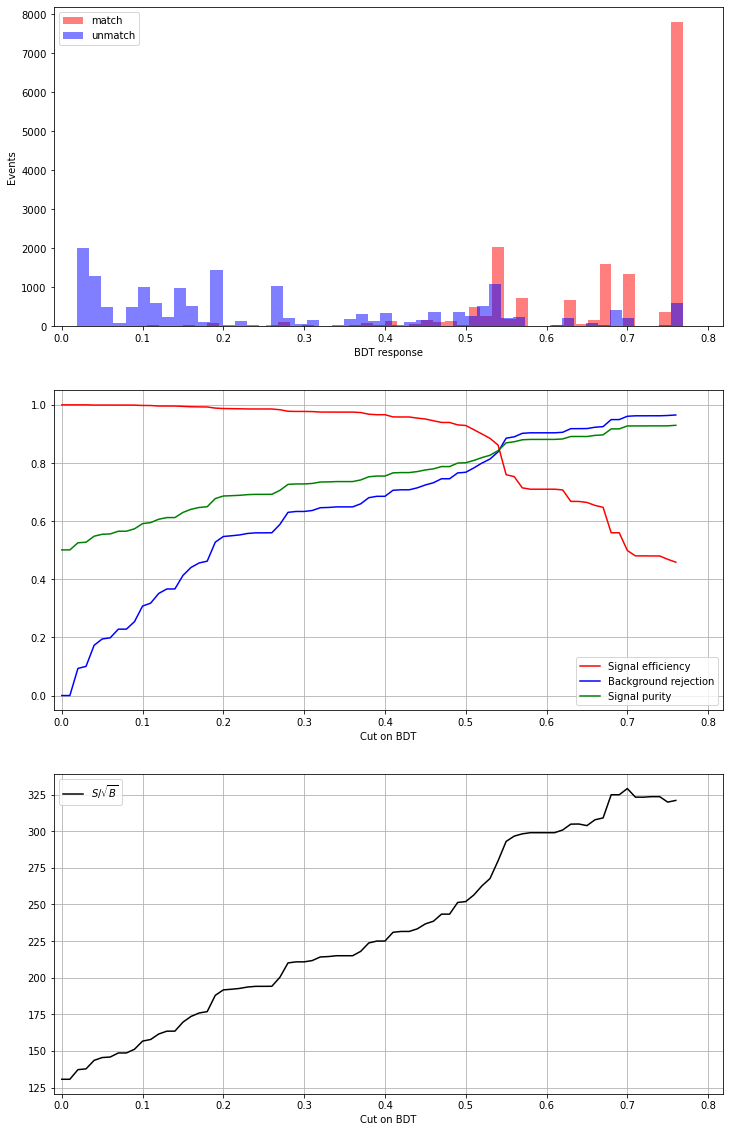

In [9]:
eval_regreesion(df_test, label_test, clf)
eval_regreesion(df_train, label_train, clf)

In [ ]:
sample = "M1-5000_R-0p3"
tempFile = TFile(f"{sample}_training.root","RECREATE")
outTree = TTree()
inFile = TFile(f"/home/xyan13/Trijet/TrijetAna/TrijetAna/outputs/Res1ToRes2GluTo3Glu_{sample}_ML_study.root")
inTree = inFile.Get("Events")
dijet_eta = np.empty((1), dtype="float32")
dijet_phi = np.empty((1), dtype="float32")
dR_jj = np.empty((1), dtype="float32")
dEta_jj = np.empty((1), dtype="float32")
dPhi_jj = np.empty((1), dtype="float32")
jet_eta_0 = np.empty((1), dtype="float32")
jet_phi_0 = np.empty((1), dtype="float32")
jet_ptoverm_0 = np.empty((1), dtype="float32")
jet_eta_1 = np.empty((1), dtype="float32")
jet_phi_1 = np.empty((1), dtype="float32")
jet_ptoverm_1 = np.empty((1), dtype="float32")
jet_eta_2 = np.empty((1), dtype="float32")
jet_phi_2 = np.empty((1), dtype="float32")
jet_ptoverm_2 = np.empty((1), dtype="float32")
dR_jj_j = np.empty((1), dtype="float32")
dEta_jj_j = np.empty((1), dtype="float32")
dPhi_jj_j = np.empty((1), dtype="float32")
jet_ptoverM_0 = np.empty((1), dtype="float32")
jet_ptoverM_1 = np.empty((1), dtype="float32")
jet_ptoverM_2 = np.empty((1), dtype="float32")
dijet_ptoverM = np.empty((1), dtype="float32")
gen_dijet_matched = np.empty((1), dtype="int32")

outTree.Branch("dijet_eta", dijet_eta, "dijet_eta/F")
outTree.Branch("dijet_phi", dijet_phi, "dijet_phi/F")
outTree.Branch("dR_jj", dR_jj, "dR_jj/F")
outTree.Branch("dEta_jj", dEta_jj, "dEta_jj/F")
outTree.Branch("dPhi_jj", dPhi_jj, "dPhi_jj/F")
outTree.Branch("jet_eta_0", jet_eta_0, "jet_eta_0/F")
outTree.Branch("jet_phi_0", jet_phi_0, "jet_phi_0/F")
outTree.Branch("jet_ptoverm_0", jet_ptoverm_0, "jet_ptoverm_0/F")
outTree.Branch("jet_eta_1", jet_eta_1, "jet_eta_1/F")
outTree.Branch("jet_phi_1", jet_phi_1, "jet_phi_1/F")
outTree.Branch("jet_ptoverm_1", jet_ptoverm_1, "jet_ptoverm_1/F")
outTree.Branch("jet_eta_2", jet_eta_2, "jet_eta_2/F")
outTree.Branch("jet_phi_2", jet_phi_2, "jet_phi_2/F")
outTree.Branch("jet_ptoverm_2", jet_ptoverm_2, "jet_ptoverm_2/F")
outTree.Branch("dR_jj_j", dR_jj_j, "dR_jj_j/F")
outTree.Branch("dEta_jj_j", dEta_jj_j, "dEta_jj_j/F")
outTree.Branch("dPhi_jj_j", dPhi_jj_j, "dPhi_jj_j/F")
outTree.Branch("jet_ptoverM_0", jet_ptoverM_0, "jet_ptoverM_0/F")
outTree.Branch("jet_ptoverM_1", jet_ptoverM_1, "jet_ptoverM_1/F")
outTree.Branch("jet_ptoverM_2", jet_ptoverM_2, "jet_ptoverM_2/F")
outTree.Branch("dijet_ptoverM", dijet_ptoverM, "dijet_ptoverM/F")
outTree.Branch("gen_dijet_matched", gen_dijet_matched, "gen_dijet_matched/I")

n_all = inTree.GetEntries()
array_ismatch = inTree.AsMatrix(columns=["gen_dijet_matched"])
array_matched = np.where((array_ismatch.ravel() == 3))[0]
n_matched = np.shape(array_matched)[0]
array_unmatched = np.where((array_ismatch.ravel() == 0))[0]
n_unmatched = np.shape(array_unmatched)[0]
print(n_matched, n_unmatched)
ratio = n_matched / n_unmatched
from ROOT import TRandom3
rand_gen = TRandom3()
count_unmatch = 0
for i, event in enumerate(inTree):
    if i%10000 == 0:
        print("Processing: ",i)
    if(event.gen_dijet_matched != 0 and event.gen_dijet_matched != 3): continue
    if(event.gen_dijet_matched == 0):
        random = rand_gen.Uniform(0,1)
        if random > ratio: 
            continue
        gen_dijet_matched[0] = 0
    else:
        gen_dijet_matched[0] = 1
    dijet_eta[0] = event.dijet_eta
    dijet_phi[0] = event.dijet_phi
    dR_jj[0] = event.dR_jj
    dEta_jj[0] = event.dEta_jj
    dPhi_jj[0] = event.dPhi_jj
    jet_eta_0[0] = event.jet_eta_0
    jet_phi_0[0] = event.jet_phi_0
    jet_ptoverm_0[0] = event.jet_ptoverm_0
    jet_eta_1[0] = event.jet_eta_1
    jet_phi_1[0] = event.jet_phi_1
    jet_ptoverm_1[0] = event.jet_ptoverm_1
    jet_eta_2[0] = event.jet_eta_2
    jet_phi_2[0] = event.jet_phi_2
    jet_ptoverm_2[0] = event.jet_ptoverm_2
    dR_jj_j[0] = event.dR_jj_j
    dEta_jj_j[0] = event.dEta_jj_j
    dPhi_jj_j[0] = event.dPhi_jj_j
    jet_ptoverM_0[0] = event.jet_ptoverM_0
    jet_ptoverM_1[0] = event.jet_ptoverM_1
    jet_ptoverM_2[0] = event.jet_ptoverM_2
    dijet_ptoverM[0] = event.dijet_ptoverM
    outTree.Fill()
df_2 = pd.DataFrame()
label_2 = pd.DataFrame()
df_2, label_2 = make_df(outTree)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df_2, label_2, test_size=0.33, random_state=1, stratify=label_2)

In [ ]:
eval_regreesion(X_test_2, y_test_2, clf)

In [ ]:
from joblib import dump, load
dump(clf, 'BDT_model_1.joblib') 